<a href="https://colab.research.google.com/github/LuisJoseMejiaRamos/CursoGitBasico/blob/main/Segmentacion_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pasos en este Tutorial**
# **En este tutorial, vamos a cubrir: texto en negrita**


1.   Antes de comenzar: asegúrese de tener acceso a la GPU
2.   Instale cualquier modelo de segmento (SAM)
3.   Descargar datos de ejemplo
4.  Cargar modelo
5.  Generación automatizada de máscaras
6.  Generación automatizada de máscaras
7.  Generar segmentación con cuadro delimitador
8.  Segmente cualquier cosa en el conjunto de datos de Roboflow Universe

**¡Vamos a empezar!**

## Antes de que empieces

Asegurémonos de que tenemos acceso a la GPU. Podemos usar el comando `nvidia-smi` para hacer eso. En caso de problemas, vaya a `Editar` -> `Configuración del portátil` -> `Acelerador de hardware`, configúrelo en `GPU` y luego haga clic en `Guardar`.

In [1]:
!nvidia-smi

Thu Jun 29 19:37:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTA:** Para facilitarnos la gestión de conjuntos de datos, imágenes y modelos, creamos una constante `HOME`.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Instale Segment Anything Model (SAM) y otras dependencias

In [3]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-v_xhjxmd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-v_xhjxmd
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=31625a1249aae7cf3b7691a2a67d90cae8523c7075df6ce716537573527e20a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ns0vkktp/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:00


### Descargar SAM weights

In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Descargar datos de ejemplo

**Nota:** Descarguemos algunas imágenes de ejemplo. Siéntase libre de usar sus imágenes o videos.

**Nota de nota:** Si es la primera vez que lo utilizan descomenten esto y corranlo.

In [7]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content
/content/data


## Cargar el modelo

In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Generación de máscaras automatizada

Para ejecutar la generación automática de máscaras, proporcione un modelo SAM a la clase `SamAutomaticMaskGenerator`. Establezca la ruta a continuación al punto de control SAM. Se recomienda ejecutar en CUDA y con el modelo predeterminado.

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [13]:
import os
IMAGE_NAME = "GOPR0198.JPG"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)
print(IMAGE_PATH)

/content/data/GOPR0198.JPG


## Generar mascaras con SAM

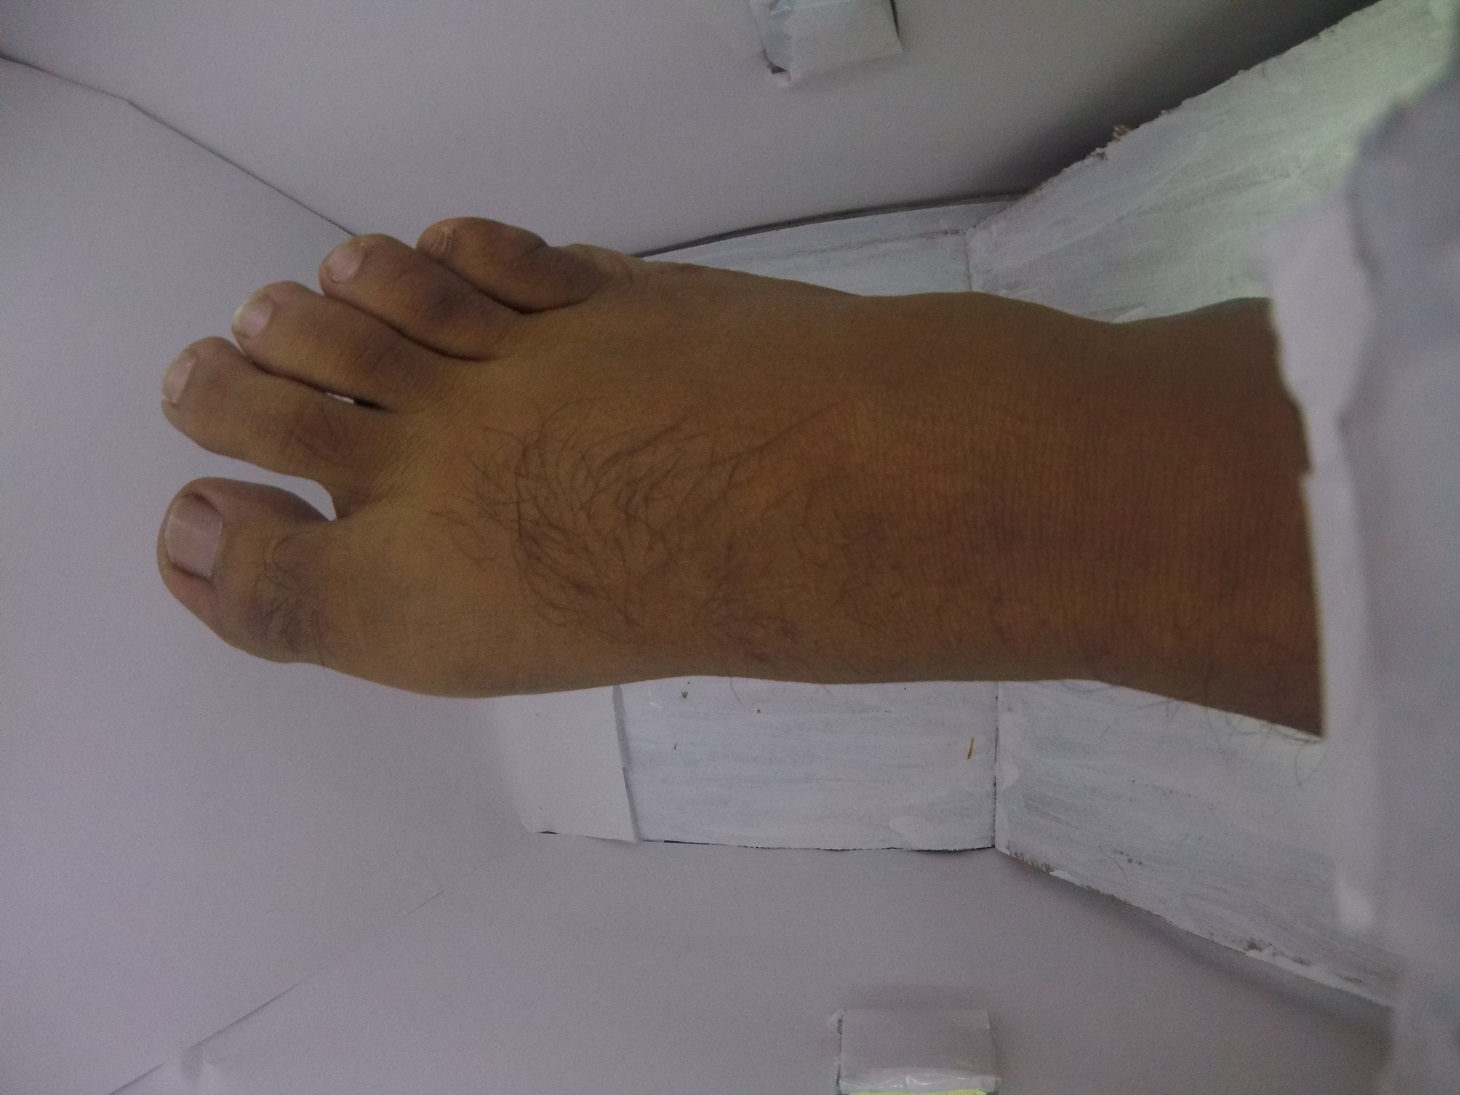

OutOfMemoryError: ignored

In [19]:
import cv2
import supervision as sv
from google.colab.patches import cv2_imshow

#image_bgr = cv2.imread("/content/data/a.jpg")
image_bgr = cv2.imread(IMAGE_PATH)
cv2_imshow(image_bgr)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)

### Formato de salida

`SamAutomaticMaskGenerator` devuelve una `lista` de máscaras, donde cada máscara es un `dict` que contiene información diversa sobre la máscara:

* `segmentación` - `[np.ndarray]` - la máscara con forma `(W, H)` y tipo `bool`
* `area` - `[int]` - el área de la máscara en píxeles
* `bbox` - `[List[int]]` - el cuadro de límite de la máscara en formato `xywh`
* `predicted_iou` - `[float]` - la propia predicción del modelo para la calidad de la máscara
* `point_coords` - `[List[List[float]]]` - el punto de entrada muestreado que generó esta máscara
* `stability_score` - `[float]` - una medida adicional de la calidad de la máscara
* `crop_box` - `List[int]` - el recorte de la imagen utilizada para generar esta máscara en formato `xywh`

In [20]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Visualización de resultados con Supervisión

A partir de la versión `0.5.0` Supervision tiene soporte nativo para SAM.

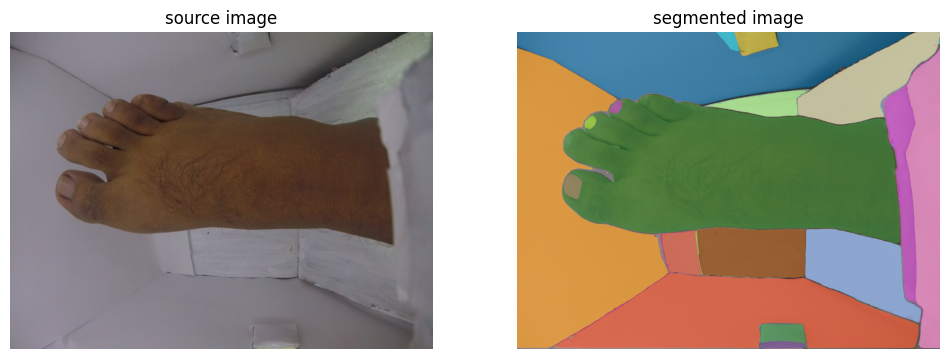

In [21]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interacción con resultados de segmentación

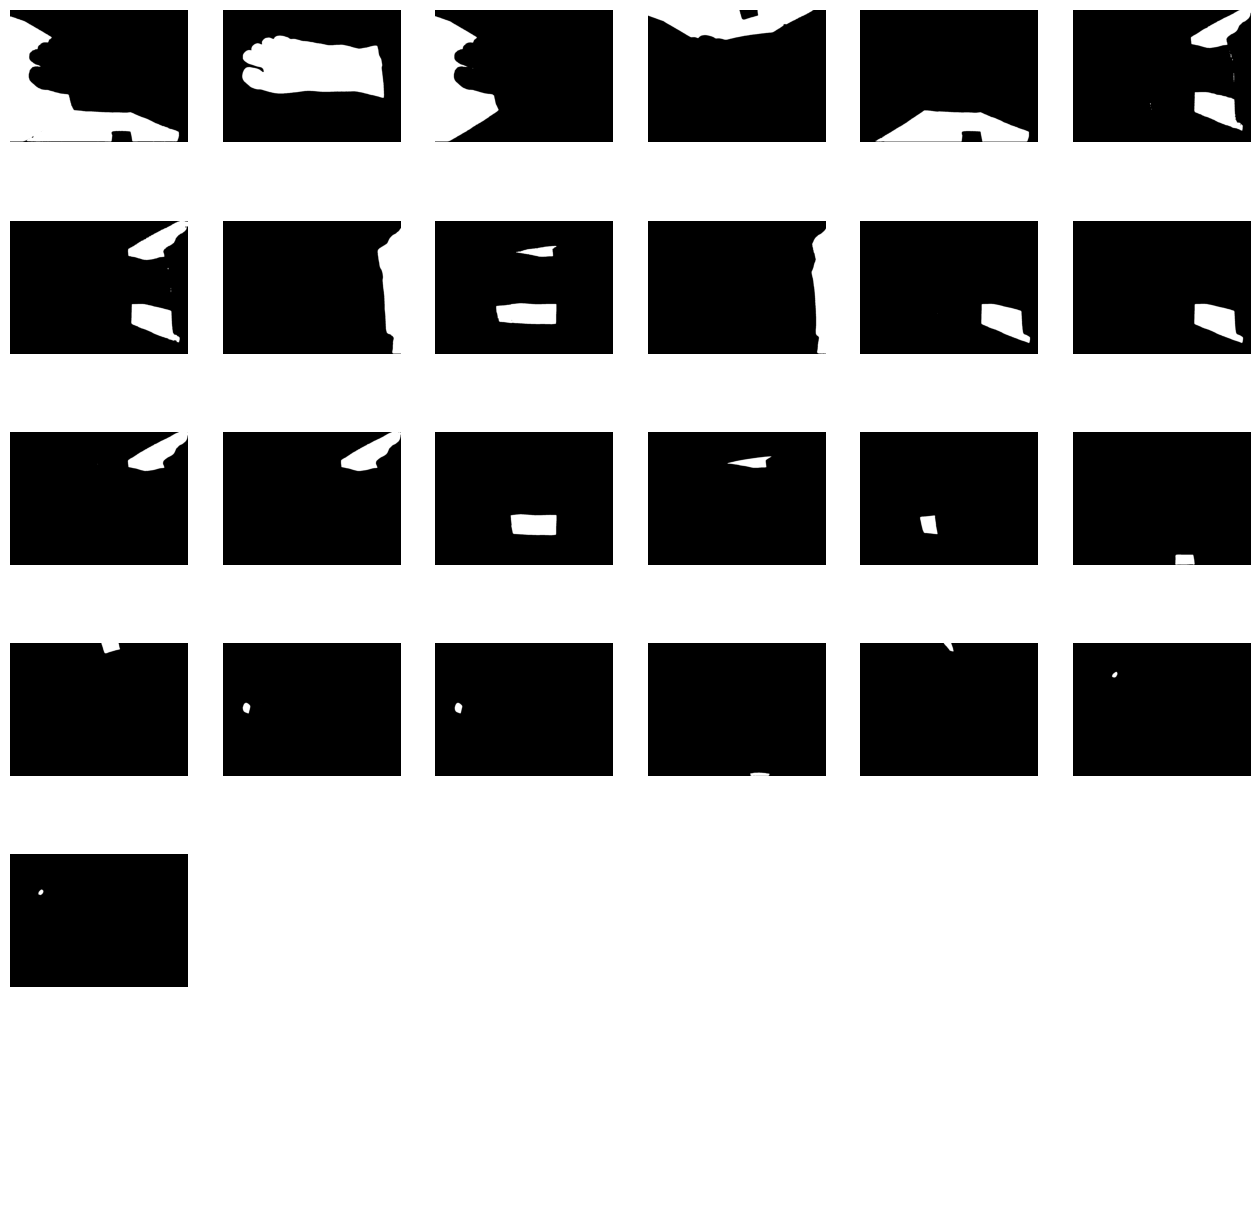

In [22]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]
img_pie = masks[1]

sv.plot_images_grid(
    images=masks,
    grid_size=(6, int(len(masks) / 4)),
    size=(16, 16)
)

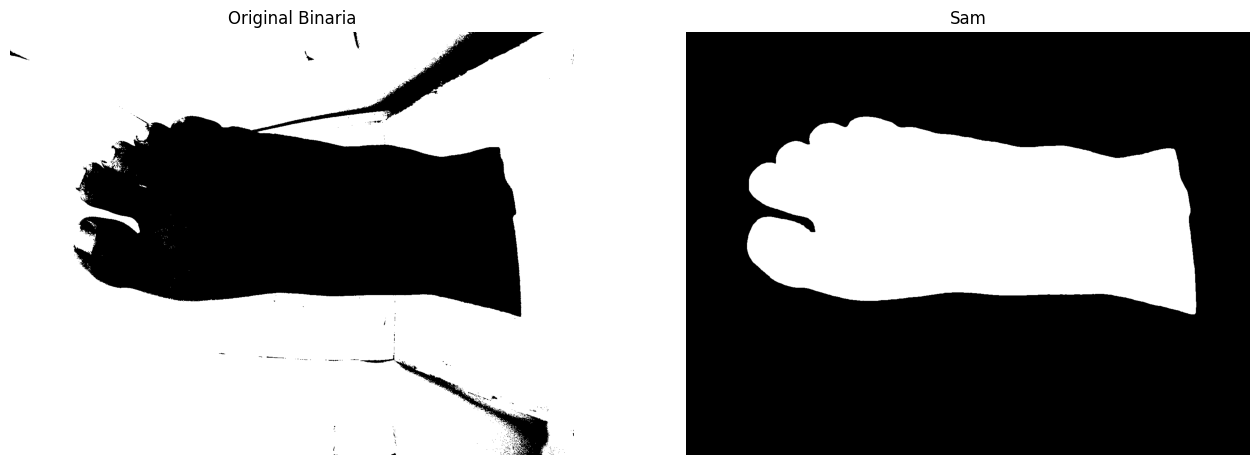

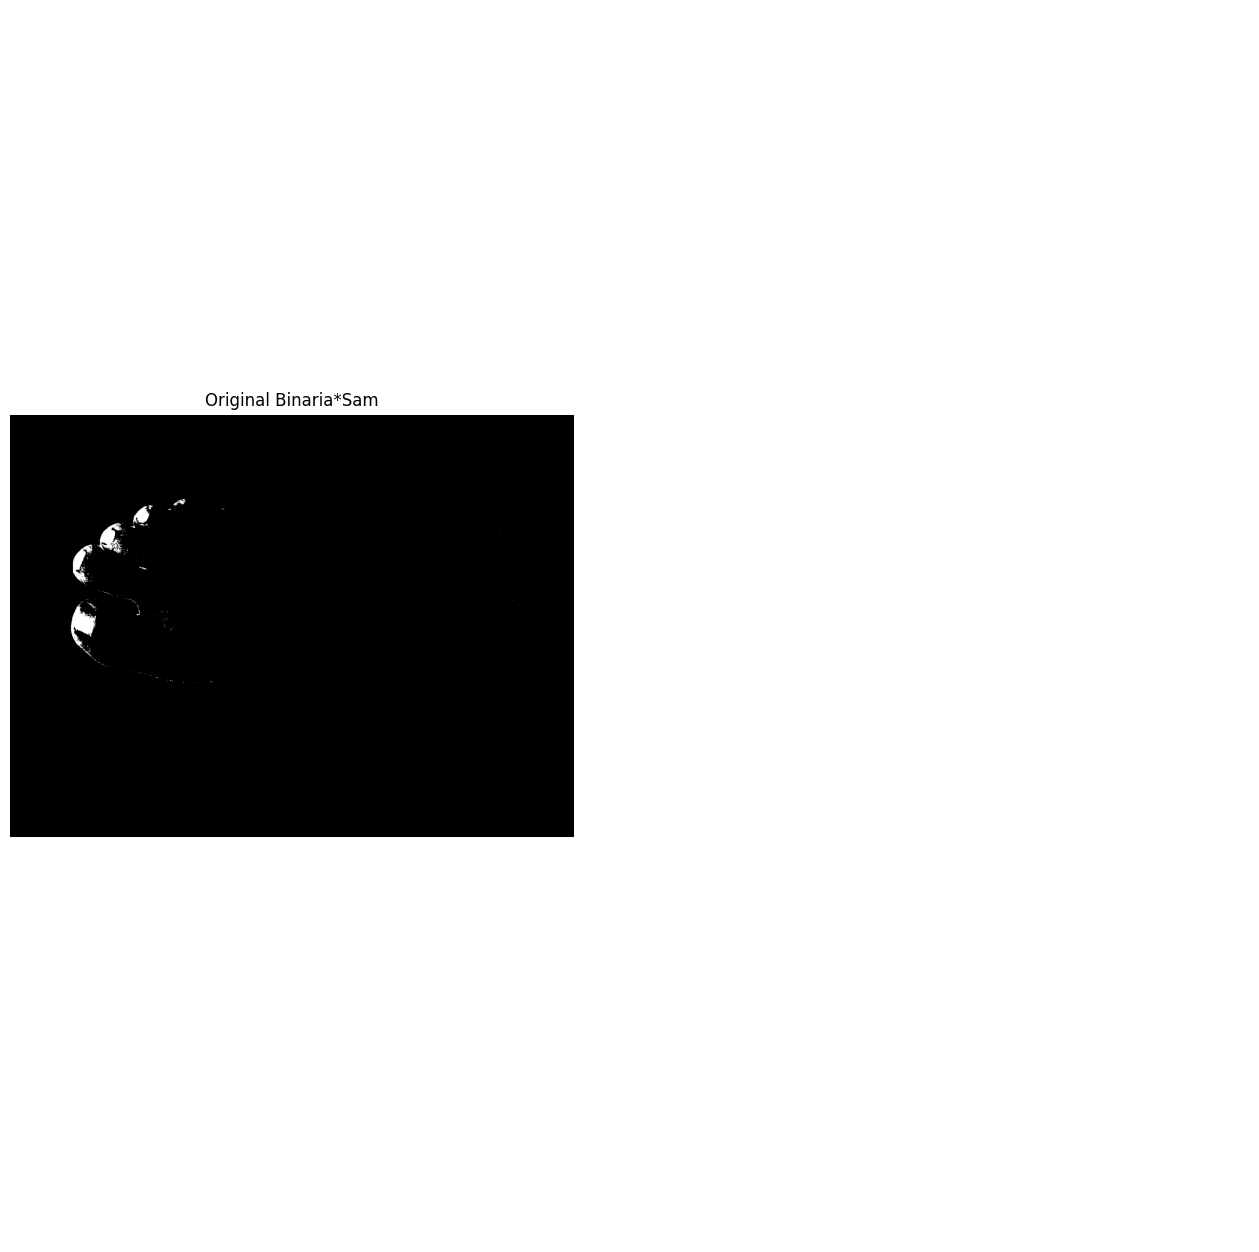

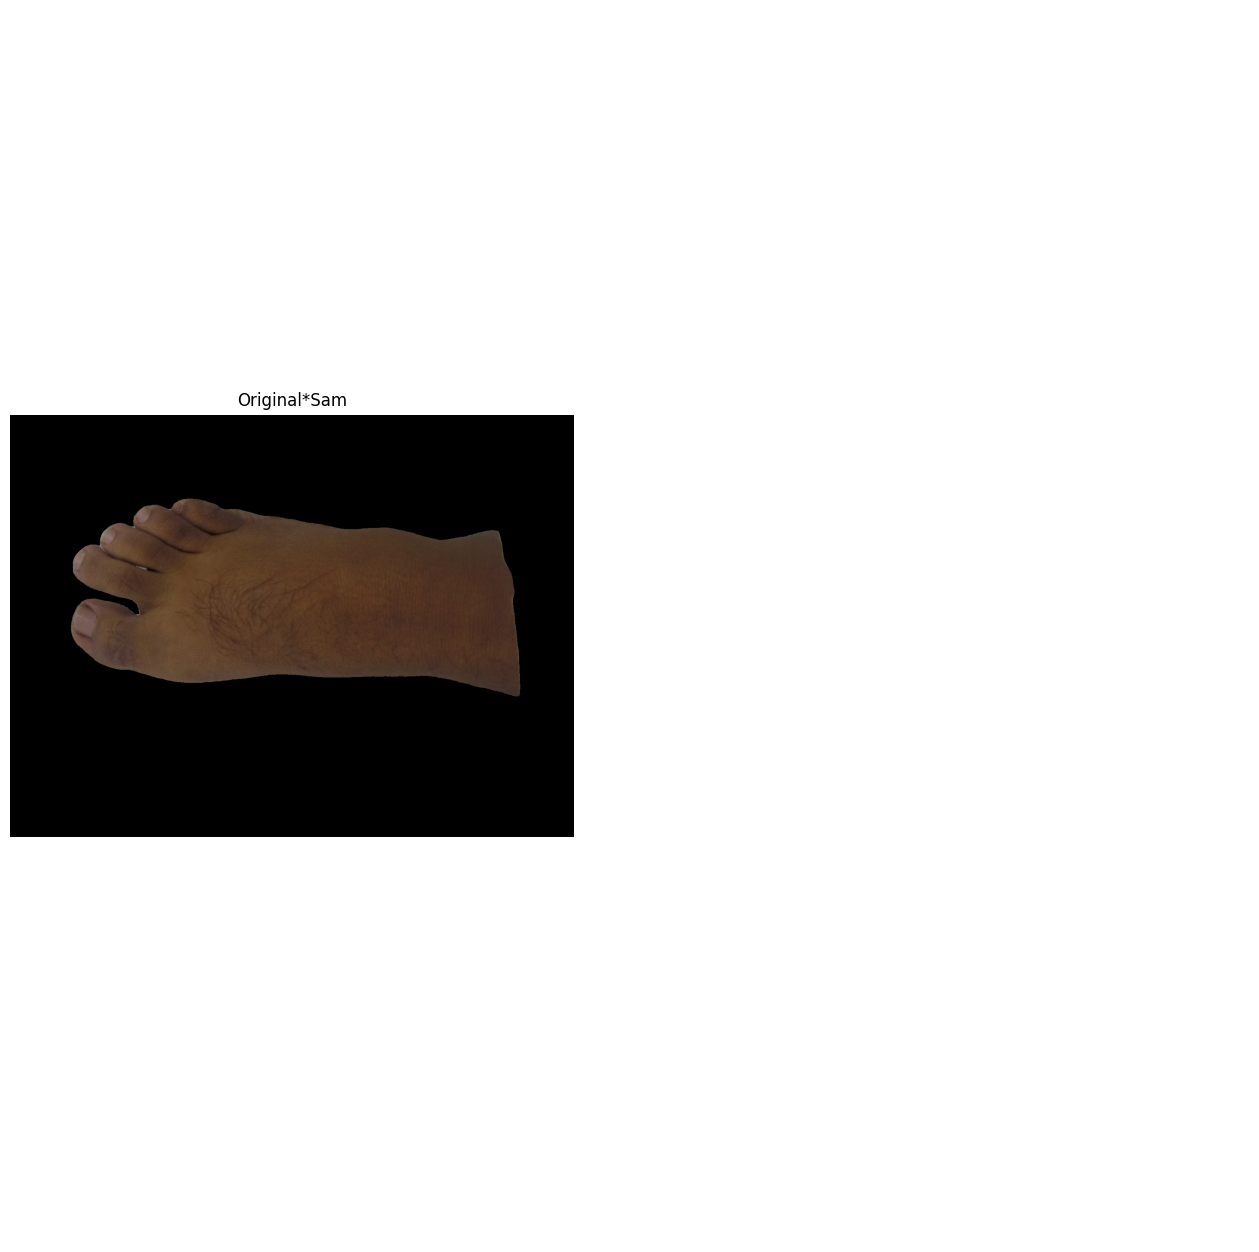

In [24]:
#print(img_pie)

imgenpie = image_bgr
umbral = (90)
imgenpie = cv2.cvtColor(imgenpie,cv2.COLOR_BGR2GRAY)
_ , imgBin = cv2.threshold(imgenpie, umbral ,255, cv2.THRESH_BINARY)

sv.plot_images_grid(
    images=[imgBin,img_pie],
    grid_size=(1,2),
    titles=['Original Binaria', 'Sam'],
    size=(16, 16)
)

img_pie = img_pie*1
#print("Arreglo Sam")
#print(img_pie)
#print("Arreglo Binarisario")
#print(imgBin)

segmentada = imgBin * img_pie

sv.plot_images_grid(
    images=[segmentada],
    grid_size=(1,2),
    titles=['Original Binaria*Sam'],
    size=(16, 16)
)


segmentada = image_bgr
segmentada[:, :, 0] = segmentada[:, :, 0] * img_pie[:,:]
segmentada[:, :, 1] = segmentada[:, :, 1] * img_pie[:,:]
segmentada[:, :, 2] = segmentada[:, :, 2] * img_pie[:,:]


sv.plot_images_grid(
    images=[segmentada],
    grid_size=(1,2),
    titles=['Original*Sam'],
    size=(16, 16)
)